### Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


### Data Download and Data arrangement

->>>>> to download the data follow jovian cnn notebook

In [2]:
### To create a dataset from folder
from torchvision.datasets import ImageFolder
import os
import tarfile

In [3]:
# Setup hyperparameters
BATCH_SIZE = 128 # good for your health: https://twitter.com/ylecun/status/989610208497360896
IMAGE_SIZE = (32,32) # (height, width) smaller images means faster computing 
NUM_EPOCHS = 3 # only run for a short period of time... we don't have all day
DATASET_NAME = "cifar10" # dataset to use (there are more in torchvision.datasets)
MACHINE = "Apple M1 Pro" # change this depending on where you're runing the code
NUM_WORKERS = 2 # set number of cores to load data

In [4]:
from timeit import default_timer as timer 

def print_train_time(start, end, device=None, machine=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    if device:  
        print(f"\nTrain time on {machine} using PyTorch device {device}: {total_time:.3f} seconds\n")
    else:
        print(f"\nTrain time: {total_time:.3f} seconds\n")
    return round(total_time, 3)

In [5]:
data_dir = "./cifar10"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


In [6]:
from torchvision import datasets, transforms

In [7]:
simple_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()])

In [8]:
train_ds = ImageFolder(data_dir +'/train', transform=simple_transform)
len(train_ds)

50000

In [9]:
test_ds = ImageFolder(root = data_dir+"/test", transform = simple_transform)
len(test_ds)

10000

In [10]:
## Split the train data to train and validation set
train_ds, valid_ds = random_split(train_ds, [40000, 10000])
len(train_ds), len(valid_ds)

(40000, 10000)

In [11]:
img, label = train_ds[0]
print(img.shape, label)
# img

torch.Size([3, 32, 32]) 0


In [12]:
print(train_ds.dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
def show_example(img, label):
    print(f"Label: {train_ds.dataset.classes[label]} -> ({str(label)})")
    plt.imshow(img.permute(1,2,0))
    plt.axis(False)

Label: airplane -> (0)


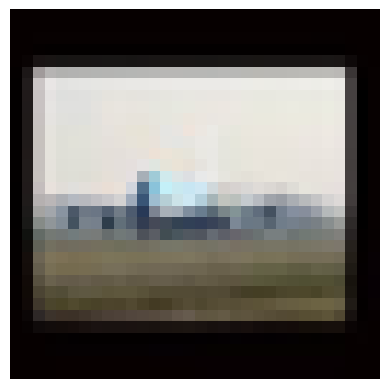

In [14]:
show_example(*train_ds[0])

Label: deer -> (4)


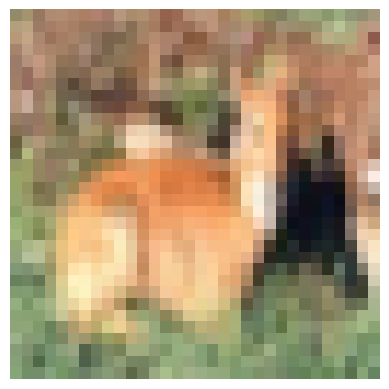

In [15]:
show_example(*train_ds[100])

In [16]:
len(train_ds)

40000

In [17]:
image,label = train_ds[0]
image.shape, image.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [18]:
label

0

In [19]:
def plot_dataset(rows, columns, dataset, figsize = (6,6), dpi = 100):
    plt.figure(figsize=figsize, dpi = dpi)
    classes = dataset.dataset.classes
    
    for i in range(1, rows*columns+1):
        rand_idx = torch.randint(0, len(dataset), size = [1]).item()
        image, label = dataset[rand_idx]
        plt.subplot(rows, columns, i)
        plt.title(f"{classes[label]}: {label}")
        plt.axis(False)
        plt.imshow(image.permute(1,2,0))
    plt.show()

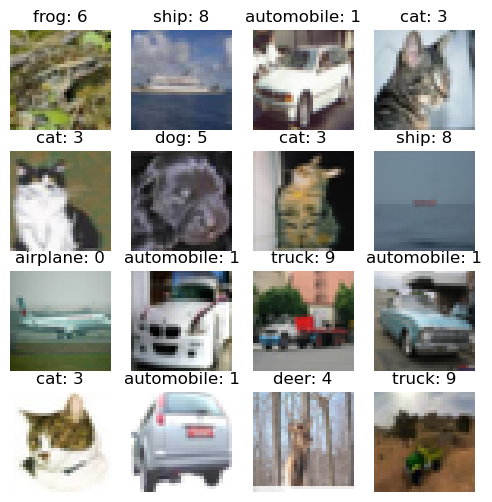

In [20]:
plot_dataset(4,4,train_ds)

### Data to Dataloader

In [21]:
## dataloader
batch_size = BATCH_SIZE
train_dl = DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True,num_workers=NUM_WORKERS,pin_memory=True)
valid_dl = DataLoader(dataset = valid_ds, batch_size = batch_size*2,num_workers=NUM_WORKERS,pin_memory=True)
test_dl = DataLoader(dataset = test_ds, batch_size = batch_size*2,num_workers=NUM_WORKERS,pin_memory=True)

In [22]:
for image, label in train_dl:
    print(f"image shape: {image.shape}")
    print(f"label shape: {label.shape}")
    break

image shape: torch.Size([128, 3, 32, 32])
label shape: torch.Size([128])


In [23]:
for image, label in valid_dl:
    print(f"image shape: {image.shape}")
    print(f"label shape: {label.shape}")
    break

image shape: torch.Size([256, 3, 32, 32])
label shape: torch.Size([256])


### Data Visualization

In [24]:
from torchvision.utils import make_grid

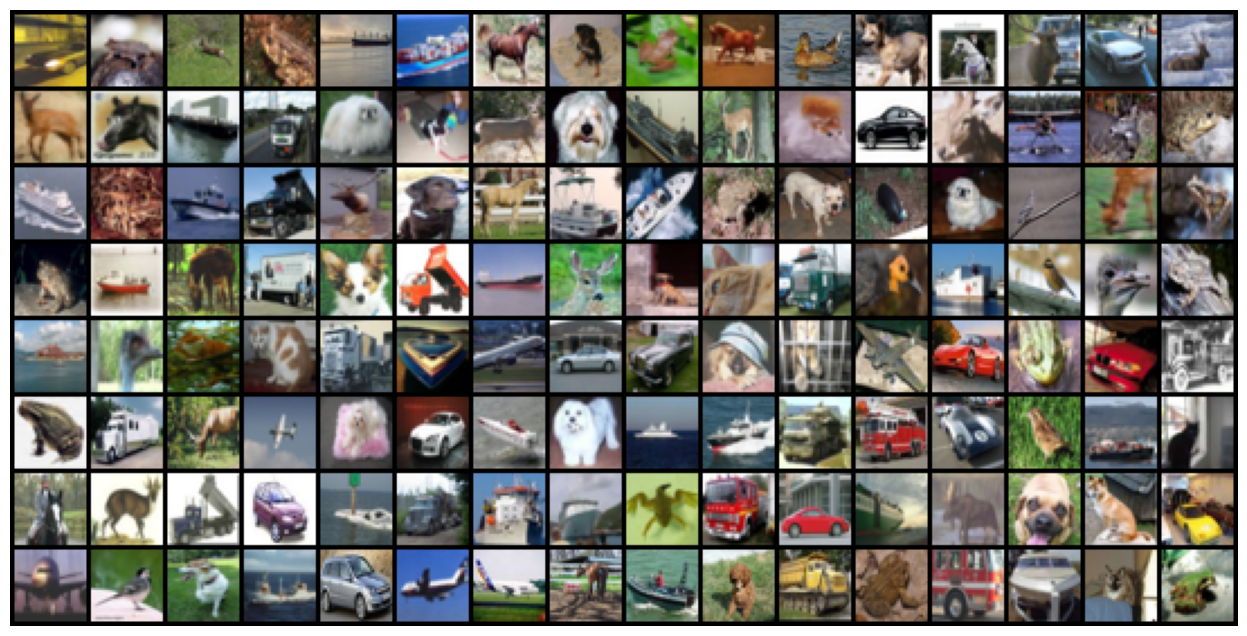

In [25]:
for image, label in train_dl:
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(image, nrow=16).permute(1,2,0))
    break

## Creating a model

In [26]:
import torch
from torch import nn
class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),  
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
          )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
#             nn.Linear(in_features=hidden_units*5*5,out_features=output_shape) # image shape 32, 32
            nn.Linear(in_features=hidden_units*5*5,out_features=output_shape) # image shape 224, 224
        )

    def forward(self, x: torch.Tensor):
# #         print(x.shape)
#         x = self.conv_block_1(x)
# #         print(x.shape)
#         x = self.conv_block_2(x)
# #         print(x.shape)
#         x = self.classifier(x)
#         return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [27]:
# Do a dummy forward pass (to test the model) 
model = TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=3)

model(torch.randn(1, 3, 32,32))

tensor([[-0.0304, -0.0176, -0.0179]], grad_fn=<AddmmBackward0>)

## 3. Setup training/testing loop(s)

In [28]:
from tqdm.auto import tqdm

In [29]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Send data to target device
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
#         X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#         X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [30]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            # Send data to target device
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
#             X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#             X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [31]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    
    print(f"[INFO] Training model {model.__class__.__name__} on device '{device}' for {epochs} epochs...")
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
#     for epoch in range(epochs):
    for epoch in range(epochs):
        # Do eval before training (to see if there's any errors)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
        
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [32]:
# Set random seed
torch.manual_seed(42)

# Create device list
device = "mps"

# for device in devices:

# Recreate an instance of TinyVGG
model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                hidden_units=10, 
                output_shape=len(train_ds.dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = train(model=model, 
                      train_dataloader=train_dl,
                      test_dataloader=valid_dl,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=NUM_EPOCHS,
                      device=device)

# End the timer
end_time = timer()

# Print out timer and results
total_train_time = print_train_time(start=start_time,
                                    end=end_time,
                                    device=device,
                                    machine=MACHINE)


[INFO] Training model TinyVGG on device 'mps' for 3 epochs...


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 1 | train_loss: 2.0680 | train_acc: 0.2220 | test_loss: 2.3042 | test_acc: 0.0990


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 2 | train_loss: 1.7191 | train_acc: 0.3746 | test_loss: 1.8069 | test_acc: 0.3440


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 3 | train_loss: 1.6026 | train_acc: 0.4211 | test_loss: 1.6301 | test_acc: 0.4105

Train time on Apple M1 Pro using PyTorch device mps: 96.093 seconds



In [33]:
print(model_results)

{'train_loss': [2.0680119122940894, 1.7190945746418766, 1.6025815048156835], 'train_acc': [0.2219698482428115, 0.37462559904153353, 0.4211012380191693], 'test_loss': [2.304198455810547, 1.8069339215755462, 1.6301118284463882], 'test_acc': [0.0990234375, 0.34404296875, 0.410546875]}


In [34]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results_2 = train(model=model, 
                      train_dataloader=train_dl,
                      test_dataloader=valid_dl,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=10,
                      device=device)

# End the timer
end_time = timer()

# Print out timer and results
total_train_time = print_train_time(start=start_time,
                                    end=end_time,
                                    device=device,
                                    machine=MACHINE)

[INFO] Training model TinyVGG on device 'mps' for 10 epochs...


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 1 | train_loss: 1.7417 | train_acc: 0.3656 | test_loss: 1.5630 | test_acc: 0.4327


  0%|          | 0/40 [01:21<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 2 | train_loss: 1.4819 | train_acc: 0.4649 | test_loss: 1.5805 | test_acc: 0.4312


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 3 | train_loss: 1.3926 | train_acc: 0.5054 | test_loss: 1.4440 | test_acc: 0.4791


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 4 | train_loss: 1.3461 | train_acc: 0.5244 | test_loss: 1.3707 | test_acc: 0.5098


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 5 | train_loss: 1.3185 | train_acc: 0.5357 | test_loss: 1.3314 | test_acc: 0.5278


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 6 | train_loss: 1.3032 | train_acc: 0.5429 | test_loss: 1.3483 | test_acc: 0.5253


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 7 | train_loss: 1.2751 | train_acc: 0.5504 | test_loss: 1.3565 | test_acc: 0.5154


  0%|          | 0/40 [01:51<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 8 | train_loss: 1.2657 | train_acc: 0.5546 | test_loss: 1.3258 | test_acc: 0.5247


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 9 | train_loss: 1.2552 | train_acc: 0.5574 | test_loss: 1.2633 | test_acc: 0.5509


  0%|          | 0/40 [00:01<?, ?it/s]

  0%|          | 0/313 [00:01<?, ?it/s]

Epoch: 10 | train_loss: 1.2516 | train_acc: 0.5580 | test_loss: 1.3264 | test_acc: 0.5319

Train time on Apple M1 Pro using PyTorch device mps: 511.653 seconds



In [35]:
print(model_results_2)

{'train_loss': [1.7417072495713402, 1.4818727992974912, 1.3926156016584403, 1.3461492263470975, 1.3184834985306468, 1.3031529110079756, 1.275148927213285, 1.2656917579638691, 1.2551998278965204, 1.2515754903467318], 'train_acc': [0.36563997603833864, 0.4649311102236422, 0.5054163338658147, 0.524385982428115, 0.5357428115015974, 0.5428813897763578, 0.5503943690095847, 0.5545626996805112, 0.5573582268370607, 0.557957268370607], 'test_loss': [1.5630109935998917, 1.5805241018533707, 1.4440363585948943, 1.3707015812397003, 1.3314171016216279, 1.348307940363884, 1.3564699441194534, 1.325792172551155, 1.2632626593112946, 1.3264471352100373], 'test_acc': [0.43271484375, 0.43115234375, 0.4791015625, 0.509765625, 0.52783203125, 0.52529296875, 0.5154296875, 0.52470703125, 0.55087890625, 0.53193359375]}


In [36]:
model_results['train_loss']+= model_results_2['train_loss']
model_results['train_acc']+= model_results_2['train_acc']
model_results['test_loss']+= model_results_2['test_loss']
model_results['test_acc']+= model_results_2['test_acc']

In [37]:
model_results

{'train_loss': [2.0680119122940894,
  1.7190945746418766,
  1.6025815048156835,
  1.7417072495713402,
  1.4818727992974912,
  1.3926156016584403,
  1.3461492263470975,
  1.3184834985306468,
  1.3031529110079756,
  1.275148927213285,
  1.2656917579638691,
  1.2551998278965204,
  1.2515754903467318],
 'train_acc': [0.2219698482428115,
  0.37462559904153353,
  0.4211012380191693,
  0.36563997603833864,
  0.4649311102236422,
  0.5054163338658147,
  0.524385982428115,
  0.5357428115015974,
  0.5428813897763578,
  0.5503943690095847,
  0.5545626996805112,
  0.5573582268370607,
  0.557957268370607],
 'test_loss': [2.304198455810547,
  1.8069339215755462,
  1.6301118284463882,
  1.5630109935998917,
  1.5805241018533707,
  1.4440363585948943,
  1.3707015812397003,
  1.3314171016216279,
  1.348307940363884,
  1.3564699441194534,
  1.325792172551155,
  1.2632626593112946,
  1.3264471352100373],
 'test_acc': [0.0990234375,
  0.34404296875,
  0.410546875,
  0.43271484375,
  0.43115234375,
  0.47910

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results_3 = train(model=model, 
                      train_dataloader=train_dl,
                      test_dataloader=valid_dl,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=10,
                      device=device)

# End the timer
end_time = timer()

# Print out timer and results
total_train_time = print_train_time(start=start_time,
                                    end=end_time,
                                    device=device,
                                    machine=MACHINE)

In [ ]:
print(model_results_3)

In [ ]:
model_results['train_loss']+= model_results_3['train_loss']
model_results['train_acc']+= model_results_3['train_acc']
model_results['test_loss']+= model_results_3['test_loss']
model_results['test_acc']+= model_results_3['test_acc']